In [323]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [308]:
## EXPLORING THE PHOTOMETRY CATALOG

In [309]:
photometry = fits.open("data/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits")

In [310]:
## ALL THE FILTERS NAMES 
photometry[1].data["NAME"]

chararray(['F090W', 'F115W', 'F150W', 'F182M', 'F200W', 'F210M', 'F277W',
           'F335M', 'F356W', 'F410M', 'F430M', 'F444W', 'F460M', 'F480M',
           'F435W', 'F606W', 'F775W', 'F814W', 'F850LP', 'F105W', 'F125W',
           'F140W', 'F160W'], dtype='<U6')

In [34]:
photometry[1].data["WAVE_MIN"]

array([0.79455, 1.0122 , 1.33079, 1.7215 , 1.7544 , 1.9916 , 2.42235,
       3.17675, 3.13486, 3.86452, 4.1672 , 3.87939, 4.51446, 4.66175,
       0.3878 , 0.4794 , 0.6998 , 0.7063 , 0.8303 , 0.9072 , 1.0993 ,
       1.2005 , 1.3995 ], dtype='>f4')

In [205]:
photometry[1].data["WAVE_PIVOT"][photometry[1].data["NAME"] == 'F200W']

array([1.9875622], dtype='>f4')

In [35]:
photometry[1].data["WAVE_MAX"]

array([1.00555, 1.2822 , 1.66879, 1.9685 , 2.2284 , 2.2016 , 3.13212,
       3.53752, 3.98208, 4.30232, 4.39961, 4.98334, 4.74823, 4.97388,
       0.4815 , 0.7088 , 0.851  , 0.8919 , 0.9517 , 1.199  , 1.3999 ,
       1.5947 , 1.6871 ], dtype='>f4')

In [ ]:
## FIND THE SOURCE 
### ARRAY INDEX: 32675 
### ID = 113585 

In [77]:
photometry[2].data["ID"][32675]

113585

In [78]:
photometry[2].data["RA"][32675], photometry[2].data["DEC"][32675]

(53.121757309547014, -27.797637916203)

In [ ]:
## ALL THE FILTERS USED IN PAPER 

In [319]:
filters = ["F090W", "F115W", "F150W","F182M", "F200W","F210M", 
               "F277W", "F335M", "F356W", "F410M","F430M", "F444W", 
              "F460M", "F480M"]

# GET THEIR WAVELENGTH PIVOT 
# micron
wave_pivot_obs = []
for fil in obs_filters:
    pivot = photometry[1].data["WAVE_PIVOT"][photometry[1].data["NAME"] == fil][0]
    wave_pivot_obs.append(pivot)
    
# GET THE PHOTOMETRY VALUE FOR EACH FILTER 
# Flux of source within circular aperture of 80% enclosed energy radius
# nJy
photometry_data = []
for fil in filters: 
    #c_ap[0] circ0 - 80%
    photometry_data.append(photometry[4].data[fil+"_"+c_ap[0]][32675])

Text(0, 0.5, 'Flux (nJy)')

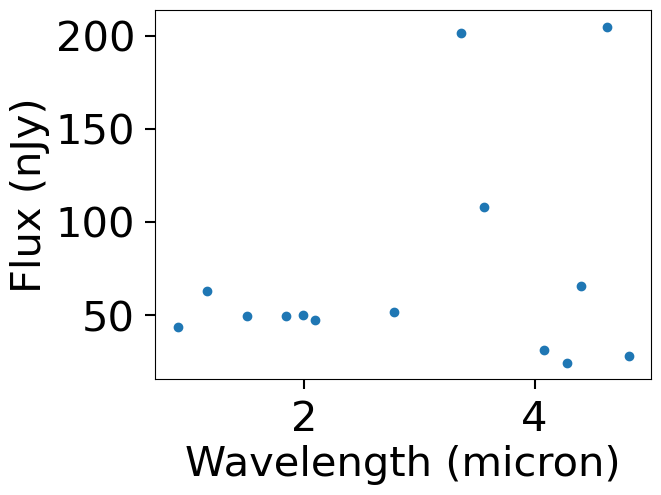

In [324]:
plt.scatter(wave_pivot_obs, photometry_data)
plt.xlabel("Wavelength (micron)")
plt.ylabel("Flux (nJy)")

In [331]:
# nJy to maggies 

In [338]:
m_AB = -2.5 * np.log10((photometry_data * u.nJy).to(u.Jansky)/(3631*u.Jansky))
obs["maggies"] = 10**(-0.4*m_AB)

In [ ]:
## Running Prospector 

In [ ]:
import fsps
import sedpy
import prospect
import emcee
import dynesty

In [328]:
### ldist for a object with z~5.9 is 5.783e4 Mpc

In [ ]:
def build_obs(snr=10, ldist=10.0, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for a single nearby dwarf galaxy 
    from Johnson et al. 2013.
    
    :param snr:
        The S/N to assign to the photometry, since none are reported 
        in Johnson et al. 2013
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    jwst = filters
    filternames = jwst
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    
    M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, 
                     -14.94, -14.09, -13.62, -13.23, -12.78])
    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm
    obs["maggies"] = 10**(-0.4*mags)

    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs["maggies_unc"] = (1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = None
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = None
    # (spectral uncertainties are given here)
    obs['unc'] = None
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = None

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

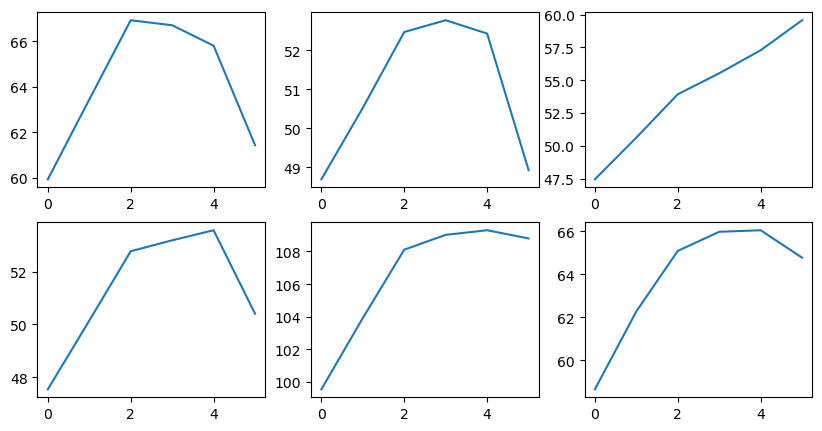

In [182]:
#filters = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F270W", "F335M"]

filters = ["F115W", "F150W", "F200W", "F277W", "F356W", "F444W"]
c_ap = ["CIRC1", "CIRC2", "CIRC3", "CIRC4", "CIRC5", "CIRC6"] #["CIRC0", "CIRC1", "CIRC2", "CIRC3", "CIRC4", "CIRC5", "CIRC6"]


fig, axs = plt.subplots(2, 3, figsize=(10, 5))
ax = axs.flatten()

for i in np.arange(6):
    circular = []
    for cir in c_ap: 
        circular.append(photometry[4].data[filters[i]+"_"+cir][32675])
    ax[i].plot(np.arange(6), circular)
        
        

In [229]:
obs_filters = ["F090W", "F115W", "F150W","F182M", "F200W","F210M", 
               "F277W", "F335M", "F356W", "F410M","F430M", "F444W", 
              "F460M", "F480M"]

wave_pivot_obs = []
for fil in obs_filters:
    print(fil)
    pivot = photometry[1].data["WAVE_PIVOT"][photometry[1].data["NAME"] == fil][0]
    wave_pivot_obs.append(pivot)


obs_data = [44.9, 64.5, 51.7, 57.6, 54, 51.3, 
            52.7, 201, 108.9, 29.8, 22.9, 65.4, 
            204.6, 28.6]

obs_data_err = [1.1, 0.8, 0.9, 1.9, 0.9, 2.1, 
                0.3, 0.5, 0.3, 0.5, 2.4, 0.4, 
               3.6, 2.4]

<ErrorbarContainer object of 3 artists>

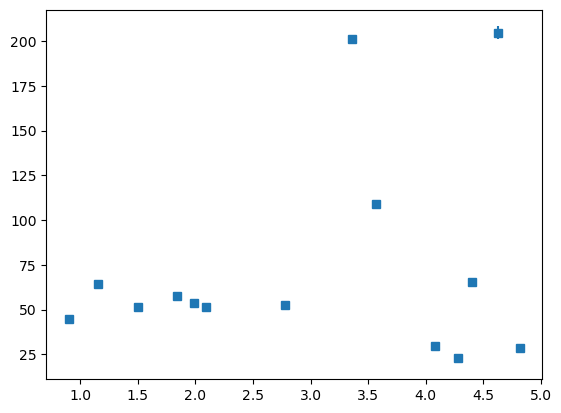

In [242]:
plt.errorbar(wave_pivot_obs, obs_data, yerr=obs_data_err, fmt="s")

In [296]:
obs_data = [44.9, 64.5, 51.7, 57.6, 54, 51.3, 
            52.7, 201, 108.9, 29.8, 22.9, 65.4, 
            204.6, 28.6]

obs_data_err = [1.1, 0.8, 0.9, 1.9, 0.9, 2.1, 
                0.3, 0.5, 0.3, 0.5, 2.4, 0.4, 
               3.6, 2.4]

In [195]:
#filters = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F270W", "F335M"]

filters = ["F115W", "F150W", "F200W", "F277W", "F356W", "F444W"]
c_ap = ["CIRC0", "CIRC1", "CIRC2", "CIRC3", "CIRC4", "CIRC5", "CIRC6"]

i=1
circular = []
for cir in c_ap: 
    circular.append(photometry[4].data[filters[i]+"_"+cir][32675])


In [311]:
filters = ["F090W", "F115W", "F150W","F182M", "F200W","F210M", 
               "F277W", "F335M", "F356W", "F410M","F430M", "F444W", 
              "F460M", "F480M"]

photometry_data = []
for fil in filters: 
    #c_ap[0] circ0 - 80%
    photometry_data.append(photometry[4].data[fil+"_"+c_ap[0]][32675])

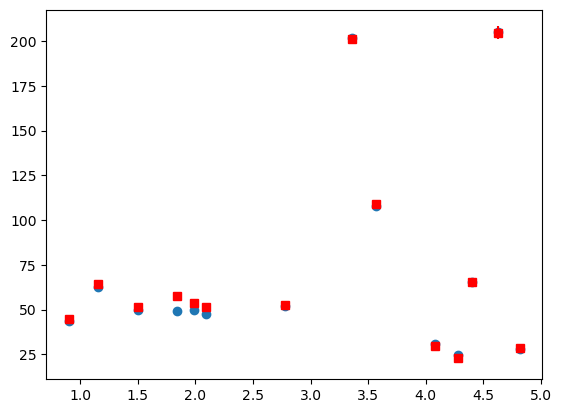

In [317]:
plt.errorbar(wave_pivot_obs, obs_data, yerr=obs_data_err, fmt="s", color="red")

plt.scatter(wave_pivot_obs, photometry_data)